In [2]:
import sys
sys.path.append('/opt/conda/pkgs')
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4506eccf78279d93d0e8a34c035e91c5_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/6bda807e3967eae797c7b1b9eeaee8db_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c2a47d89d1d34e789fdf782557bb7194_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c6c5514ada15b890fb27d1e36371554c_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/d964a294c2d0fef56a434c021026281e_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/e1c932db5cd4271709e54d8028824bc9_/lib/python3.12/site-packages")
import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import scipy as sp
import seaborn
import sharedmem
import pygraphviz


plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300


sys.path.append("scripts")
sys.path.append("../../scripts")

In [3]:
from data_io import is_fwd_id, get_fwd_id, get_sibling_id
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from truth import get_overlaps
from evaluate import NearestNeighborsConfig, mp_compute_nearest_neighbors
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

/home/miaocj/docker_dir/kNN-overlap-finder/scripts/../lib


In [4]:
MAX_SAMPLE_SIZE = int(1e9)
COVERAGE_DEPTH = 20
max_n_neighbors = 20

In [5]:
npz_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/Ecoli/all/ONT/kmer_k16/feature_matrix.npz"
tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/Ecoli/all/ONT/kmer_k16/metadata.tsv.gz"
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/Ecoli/all/ONT/kmer_k16/read_features.json.gz"
nbr_path = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/Ecoli/all/ONT/kmer_k16/WeightedLowHash_Jaccard_None_TF-IDF_nbr_matrix.npz'
time_path = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/Ecoli/all/ONT/kmer_k16/WeightedLowHash_Jaccard_None_TF-IDF_time_usage.json'

fig_path = '/home/miaocj/docker_dir/kNN-overlap-finder/evaluation/Ecoli/all/ONT/kmer_k16/WeightedLowHash_Jaccard_None_TF-IDF_tryfig.png'



In [6]:
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}
feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

In [27]:
len(read_features)

70368

In [7]:
with open(time_path, 'rb') as file:  
    time_dict = pickle.load(file) 
data = np.load(nbr_path, allow_pickle=True) 
nbr_indices = data['arr_0']

In [18]:
nbr_indices[30]

array([41374, 68541, 46551, 66248, 27607, 52312, 50699, 66247, 34819,
        8095, 29582, 61363, 45859, 51370,   642, 32526, 61102,  7173,
       47649, 56498])

In [9]:
read_ids = np.array(list(read_features))
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)

for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graphs[k] = graph

In [22]:
len(read_features)

70368

In [10]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

(70368, 5756358, 136326, 2)

In [11]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,
    seed: int = 4829, verbose=True):
    axes = []
    new_graphs = []
    figures = []
    g = graphs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    figures.append(fig)
    ax1.set_title("All edges")
    ax2.set_title("Correct edges")
    
    g = g.copy()
    remove_small_components(g, min_component_size=min_component_size)
    new_graphs.append(g)
    axes.append(ax1)

    g = g.copy()
    remove_false_edges(g, reference_graph)
    remove_small_components(g, min_component_size=min_component_size)
    new_graphs.append(g)
    axes.append(ax2)

    fig.suptitle(fig_path, ha="center", va="bottom", wrap=True, size=7)
    print(new_graphs)
    query_graphs = new_graphs

    pos = get_graphviz_layout(
        graph=query_graphs[1],
        figsize=figsize,
        seed=seed,
        layout_method=layout_method,
    )
    plot_read_graph(
        ax=axes[1],
        query_graph=query_graphs[1],
        reference_graph=reference_graph,
        metadata=metadata,
        pos=pos,
        node_size=node_size,
    )
   
    return fig

[<graph.OverlapGraph object at 0x7fc2a7c990a0>, <graph.OverlapGraph object at 0x7fc263c2f6b0>]


FileNotFoundError: [Errno 2] No such file or directory: '/home/miaocj/docker_dir/kNN-overlap-finder/evaluation/Ecoli/all/ONT/kmer_k16/WeightedLowHash_Jaccard_None_TF-IDF_tryfig.png'

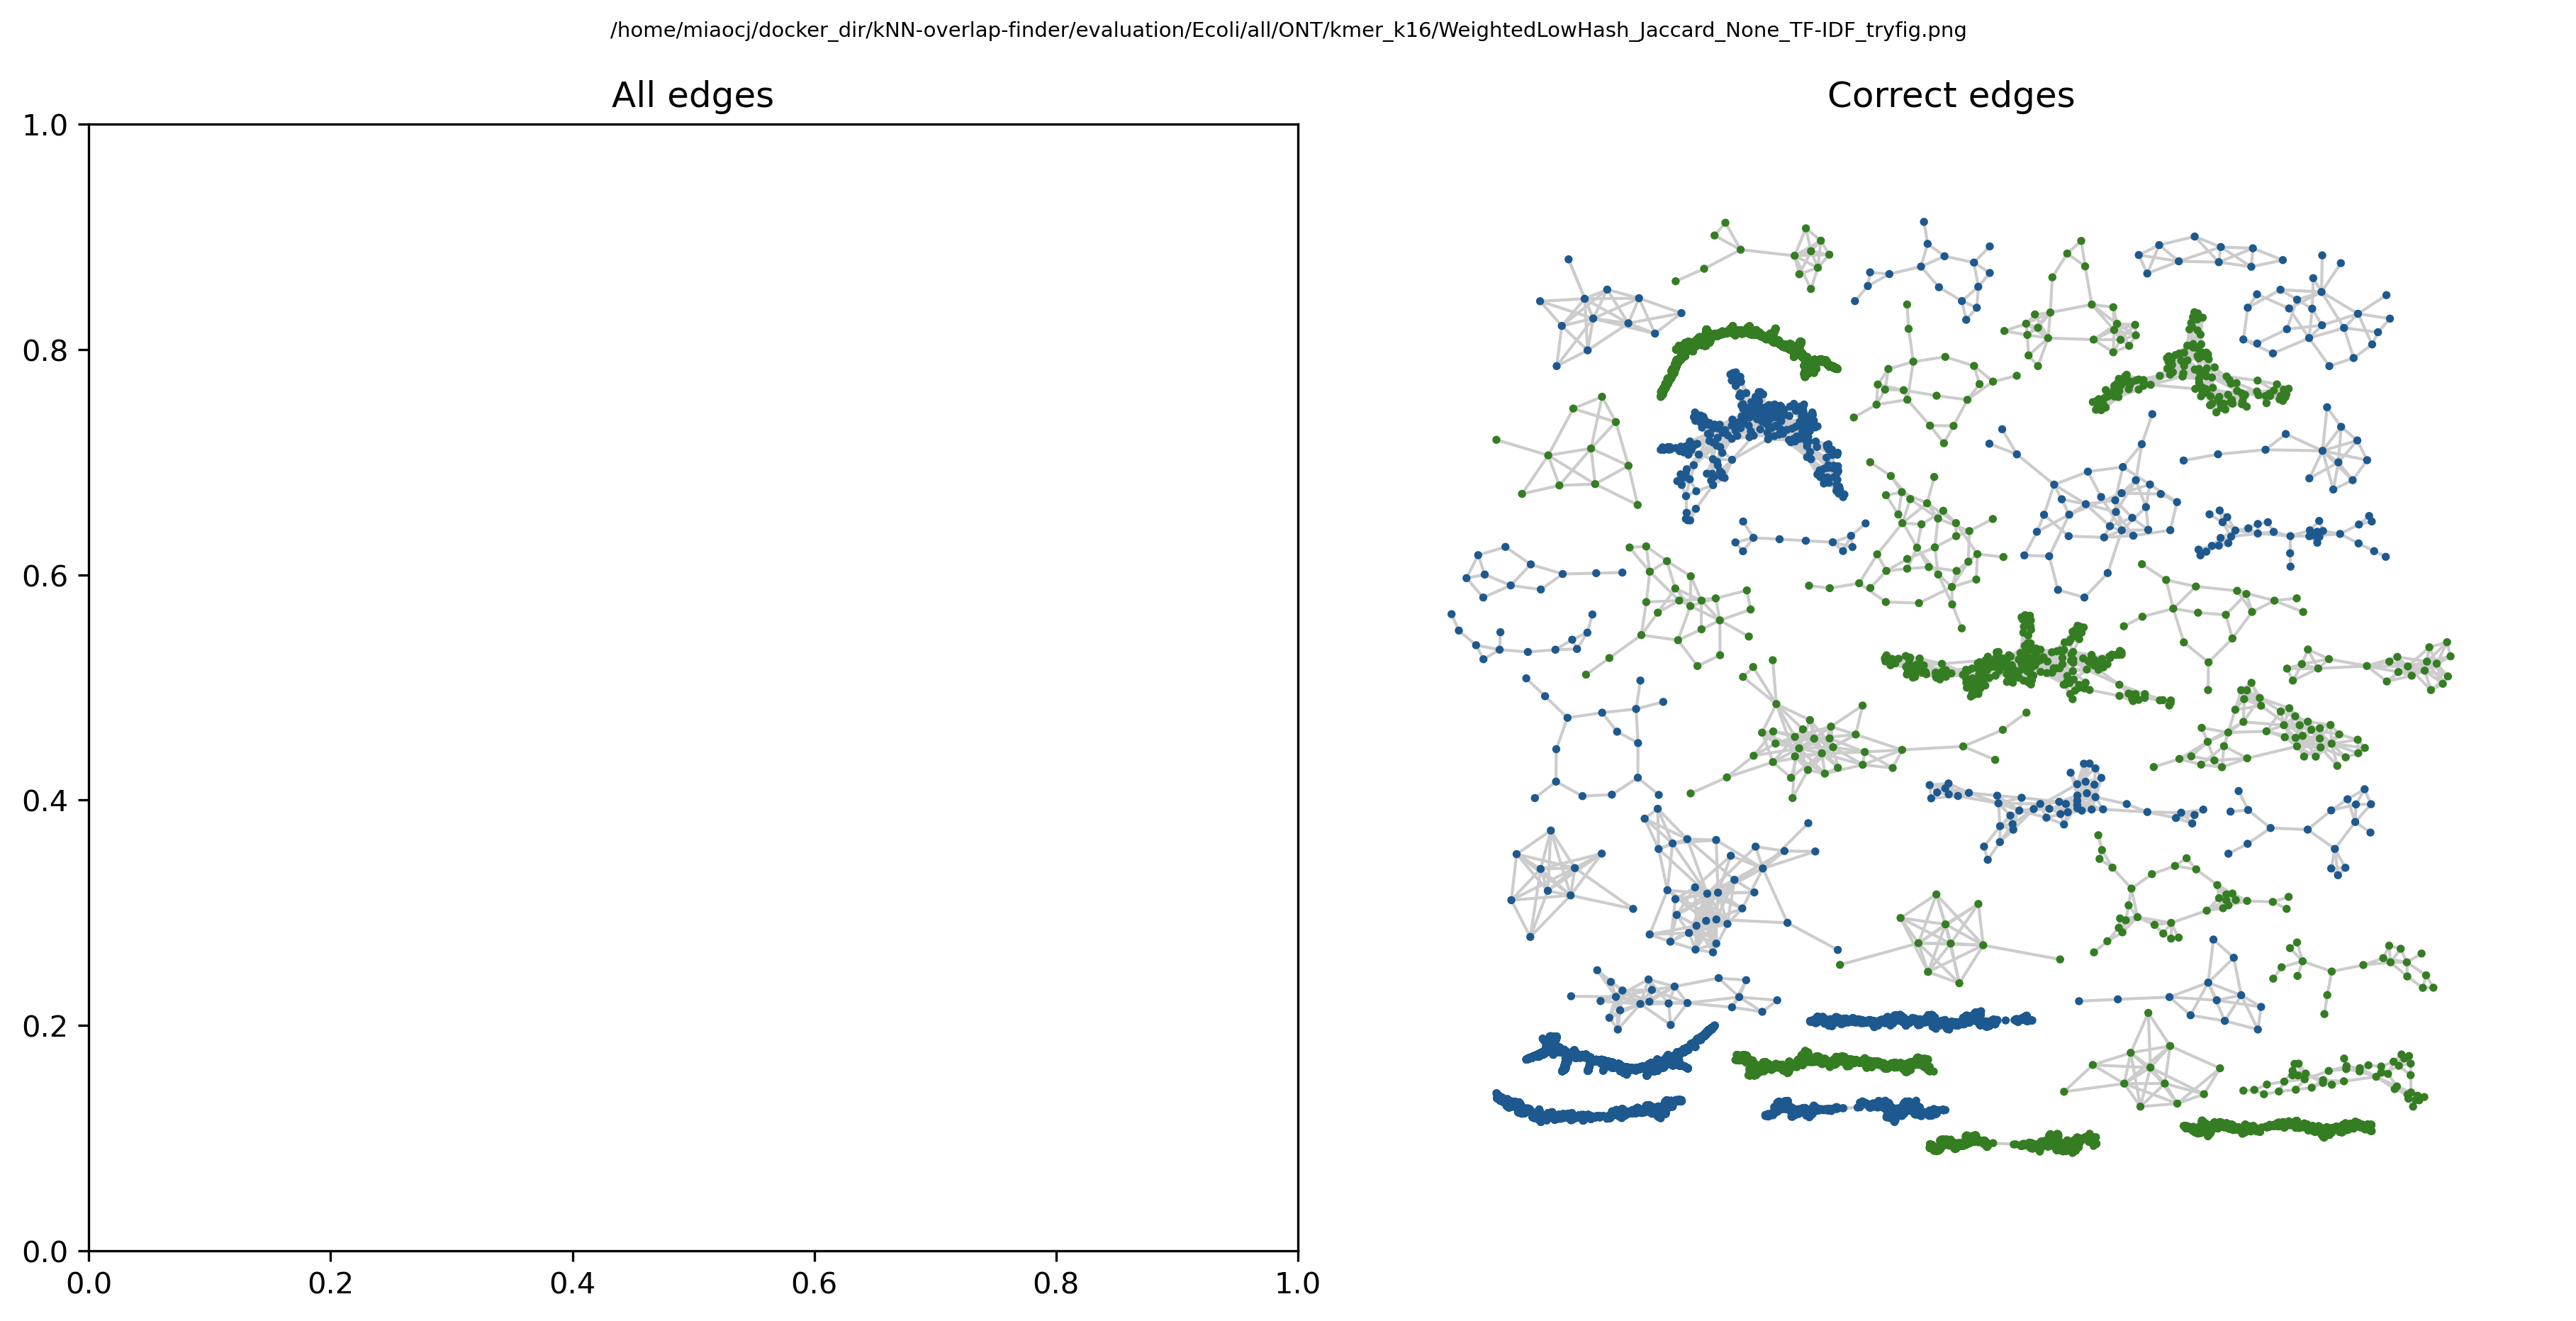

In [12]:
%%time
k6_graphs = graphs[6]
figures = plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp"
)
figures.savefig(fig_path,dpi=300,bbox_inches='tight')

[<graph.OverlapGraph object at 0x7f1ef63f57c0>, <graph.OverlapGraph object at 0x7f1ef62c7a10>]


FileNotFoundError: [Errno 2] No such file or directory: '/home/miaocj/docker_dir/kNN-overlap-finder/evaluation/Ecoli/all/ONT/kmer_k16/Exact_Euclidean_None_TF-IDF_tryfig.png'

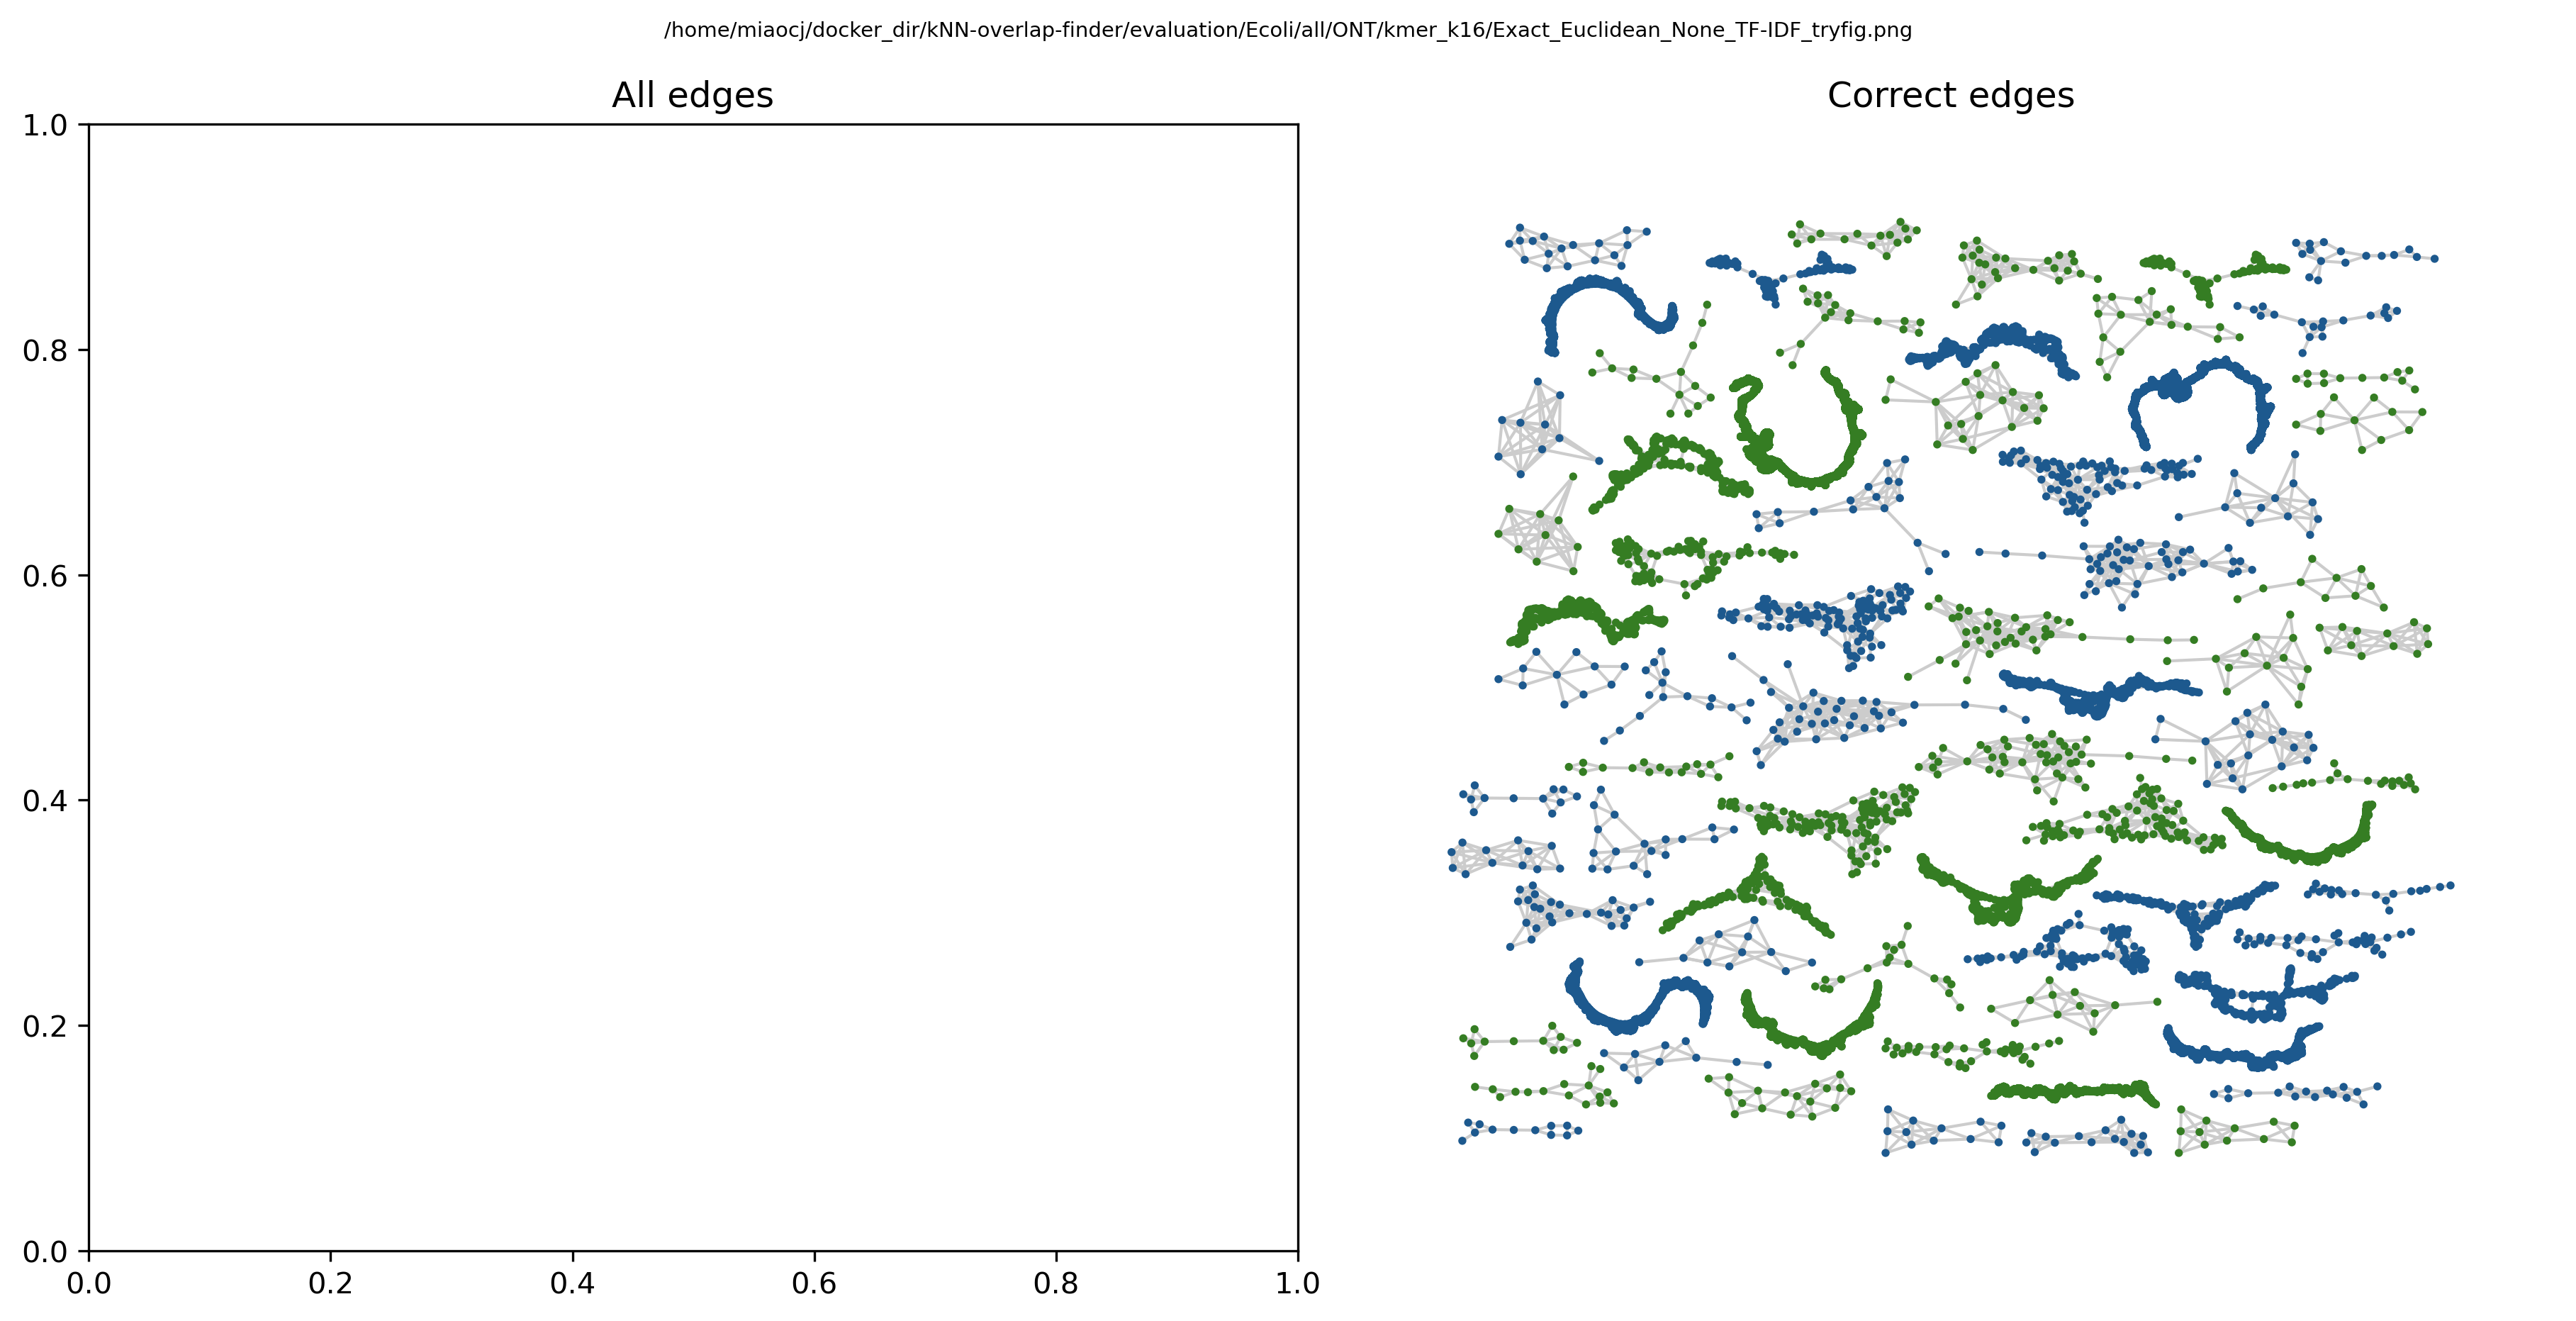

In [61]:
%%time
k6_graphs = graphs[6]
figures = plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp"
)
figures.savefig(fig_path,dpi=300,bbox_inches='tight')

In [36]:
len(query_graphs)

NameError: name 'query_graphs' is not defined

In [32]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,
    seed: int = 4829, verbose=True):
    axes = []
    figures = []

    new_graphs = []
    for g in graphs:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        figures.append(fig)
        ax1.set_title("All edges")
        ax2.set_title("Correct edges")
        
        g = g.copy()
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax1)

        g = g.copy()
        remove_false_edges(g, reference_graph)
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax2)

        fig.suptitle('method', ha="center", va="bottom", wrap=True, size=7)

    query_graphs = new_graphs
    def plot(i, pos):
        plot_read_graph(
            ax=axes[i],
            query_graph=query_graphs[i],
            reference_graph=reference_graph,
            metadata=metadata,
            pos=pos,
            node_size=node_size,
        )

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            if layout_method == "umap":
                pos = get_umap_layout(graph=query_graphs[i])
            else:
                pos = get_graphviz_layout(
                    graph=query_graphs[i],
                    figsize=figsize,
                    seed=seed,
                    layout_method=layout_method,
                )
            return i, pos

        def reduce(i, pos):
            if verbose:
                print(i, end=" ")
            plot(i, pos)

        pool.map(work, range(len(query_graphs)), reduce=reduce)
        if verbose:
            print("")

    return figures